# No Sample Background Correction
Uses the no sample, sample signal to correct for background signal in sample signals

In [24]:
import os.path as path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy.signal import savgol_filter as savgol
from scipy.optimize import minimize_scalar
import thot

import bric_analysis_libraries.plot as plot
import bric_analysis_libraries.standard_functions as stdfn

In [2]:
plot.set_plot_defaults()

In [3]:
db = thot.ThotProject( dev_root = '../s9/PLQY' )

In [4]:
# seperate assets
em_filter = '450LPF'
assets = db.find_assets( { 'type': 'raw PL spectrum' } )

no_samples = thot.filter( { 'metadata.name': 'no sample' }, assets )
no_sample = thot.filter( { 'metadata.em_filter': em_filter }, no_samples )[ 0 ]

samples = thot.filter( { 'metadata.em_filter': em_filter }, assets )
samples = list( filter( lambda asset: asset not in no_samples, samples ) )

In [5]:
# group samples
names = { sample.metadata[ 'name' ] for sample in samples }
groups = {}
for name in names:
    groups[ name ] = thot.filter( { 'metadata.name': name }, samples )

### import group data

In [6]:
def import_asset_spectra( asset, name ):
    return pd.read_csv(
        asset.file,
        header = None,
        index_col = 0,
        names = ( 'wavelength', name )
    )

In [7]:
ndf = import_asset_spectra( no_sample, 'no' )

df = []
for gname, group in groups.items():
    for asset in group:
        if asset.metadata[ 'fsip' ] == 'fs':
            name = 'fs'

        else:
            if asset.metadata[ 'inboob' ] == 'inbeam':
                name = 'in'

            else: 
                name = 'out'

        tdf = import_asset_spectra( asset, name )
        tdf.columns = pd.MultiIndex.from_tuples( [
            ( gname, head ) for head in tdf.columns
        ], names = ( 'group', 'spectra' ) )

        df.append( tdf )

df = pd.concat( df, axis = 1 ).sort_index( axis = 1 )

In [8]:
df.head()

group      9 - 25mw           9 - 50mw         
spectra          fs   in  out       fs   in out
wavelength                                     
404.65933       113  122  -51        9  130  33
405.08258      -204   96 -106       62   11 -28
405.50583        56 -144 -130        9  -93 -51
405.92908         6  190  -94      102  177 -91
406.35233        45 -113  -46      227  -61 -27

### remove outliers

In [9]:
outlier_threshold = 3

cdf = df[ ( np.abs( zscore( df ) ) < outlier_threshold ) ]

### smooth curves

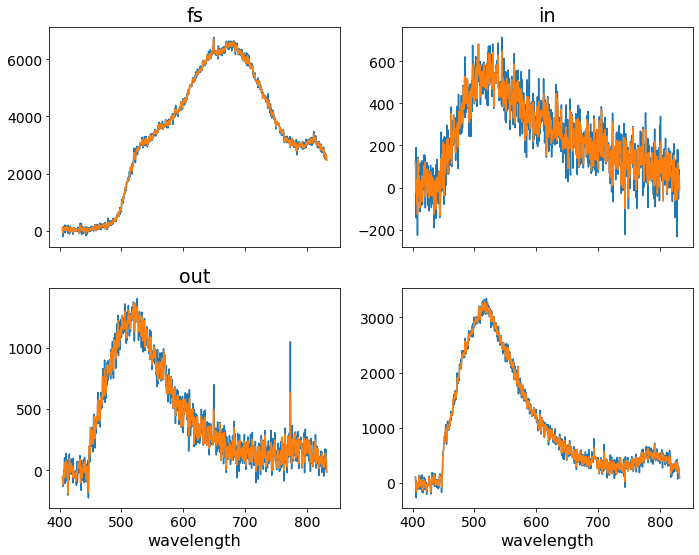

In [10]:
sdf = stdfn.resample( cdf, 'samples', cdf.shape[ 0 ] )
sndf = stdfn.resample( ndf, 'samples', ndf.shape[ 0 ] )

if db.dev_mode():
    # plot group results
    gname = '9 - 25mw'
    gdf = cdf.xs( gname, level = 'group', axis = 1 )
    fig, axs = plt.subplots( 2, 2, sharex = True )
    for ax, ( name, tdf ) in zip( axs.flatten(), gdf.items() ):
        tsdf = sdf[ ( gname, name ) ]

        tdf.plot( c = 'C0', ax = ax )
        tsdf.plot( c = 'C1', ax = ax )

        ax.set_title( name )
    
    ax = axs[ -1, -1 ] 
    ndf.plot( ax = ax, legend = False )
    sndf.plot( ax = ax, legend = False )

    fig.tight_layout()

In [11]:
window = 0.05  # window size percent
window = int( window* sdf.shape[ 0 ] )
if not window %2:
    # ensure odd window
    window += 1

sdf = sdf.apply( lambda x: savgol( x, window_length = window, polyorder = 2 ) )
sndf = sndf.apply( lambda x: savgol( x, window_length = window, polyorder = 2 ) )

for gname in groups.keys():
    # plot group results
    gname = '9 - 25mw'
    gdf = df.xs( gname, level = 'group', axis = 1 )
    fig, axs = plt.subplots( 2, 2, sharex = True )
    for ax, ( name, tdf ) in zip( axs.flatten(), gdf.items() ):
        tsdf = sdf[ ( gname, name ) ]

        tdf.plot( c = 'C0', ax = ax )
        tsdf.plot( c = 'C1', ax = ax )

        ax.set_title( name )
        
    ax = axs[ -1, -1 ] 
    ndf.plot( ax = ax, legend = False )
    sndf.plot( ax = ax, legend = False )

    fig.tight_layout()
    
    asset = {
        'file': f'{gname}-smoothing_plot-no_sample_bg_correction.png'
    }
    
    asset_path = db.add_asset( asset )
    plot.save_figure( asset_path, fig = fig )
    
    plt.close()

### scale signals
no sample scales on high energy side of in beam and out beam.

in beam and out beam scale on low energy side of free space.

In [12]:
def scale_fit( df, target ):
    """
    Scale data to as closely match a target on their overlapping domain.
    
    :param df: Series to scale.
    :param target: Target Series.
    :returns: Best fit scaling factor.
    """
    df = df.dropna()
    target = target.dropna()
    
    idx_min = max( df.index.min(), target.index.min() )
    idx_max = min( df.index.max(), target.index.max() )
    
    rdf = df[ ( df.index > idx_min ) & ( df.index < idx_max ) ]
    tdf = target[ ( target.index > idx_min ) & ( target.index < idx_max ) ]
    
    def _cost( a ):
        diff = ( a* rdf ).subtract( tdf, axis = 0 )
        diff = stdfn.integrate_df( diff ).apply( np.square )
        return diff.values[ 0 ]
    
    fit = minimize_scalar( _cost, bounds = ( 0, None ) )
    
    return ( fit.x, fit )

In [13]:
odf = df.xs( 'out', level = 'spectra', axis = 1 )
idf = df.xs( 'in', level = 'spectra', axis = 1 )

# free space, low energy scale
fsdf = sdf.xs( 'fs', level = 'spectra', axis = 1 )
fs_peak = fsdf.idxmax()

fsdf = cdf.xs( 'fs', level = 'spectra', axis = 1 )
fs_mask = fsdf.apply( lambda x: ( x.index > fs_peak[ x.name ] ) )
fsdf_scale = fsdf[ fs_mask ]

# no sample, high energy scale
ns_peak = sndf.idxmax()[ 'no' ]
ndf_scale = ndf[ ndf.index < ns_peak ]

In [14]:
scales = pd.DataFrame()
for gname in groups.keys():
    # no sample fits
    a_out, out_fit = scale_fit( ndf_scale, odf[ gname ] )
    a_in, in_fit = scale_fit( ndf_scale, idf[ gname ] )

    # free space fit
    a_fs, fs_fit = scale_fit( fsdf_scale[ gname ], idf[ gname ] )
    
    scales[ gname ] = [ a_out, out_fit, a_in, in_fit, a_fs, fs_fit ]
    
scales.index = pd.MultiIndex.from_product(
    ( ( 'out', 'in', 'fs' ), ( 'a', 'fit' ) ),
    names = ( 'signal', 'fit' )
)

scales = scales.sort_index( axis = 1 )

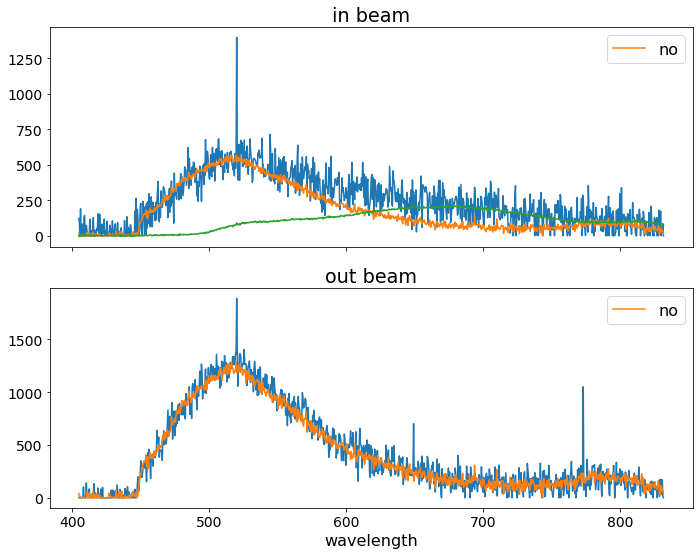

In [19]:
if db.dev_mode():
    gname = '9 - 25mw'
    
    scale = scales[ gname ].xs( 'a', level = 'fit' )
    fig, axs = plt.subplots( 2, sharex = True )
    
    # in beam
    ax = axs[ 0 ]
    ax.set_title( 'in beam' )
    idf[ gname ].clip( lower = 0 ).plot( ax = ax )
    ( ndf* scale[ 'in' ] ).clip( lower = 0 ).plot( ax = ax )
    ( fsdf[ gname ]* scale[ 'fs' ] ).plot( ax = ax )

    # out beam
    ax = axs[ 1 ]
    ax.set_title( 'out beam' )
    odf[ gname ].clip( lower = 0 ).plot( ax = ax )
    ( ndf* scale[ 'out' ] ).clip( lower = 0 ).plot( ax = ax )

    fig.tight_layout()

### correct signal

In [20]:
corr = []
for gname in groups.keys():
    scale = scales[ gname ].xs( 'a', level = 'fit' )
    
    # in beam
    corr_df = ndf[ 'no' ]* scale[ 'in' ]
    corr_df, cidf = stdfn.common_reindex( [ corr_df, idf[ gname ] ] )

    cidf = cidf.subtract( corr_df, axis = 0 )
    cidf = cidf.rename( ( gname, 'in' ) )
    corr.append( cidf )
    
    # out bemam
    corr_df = ndf[ 'no' ]* scale[ 'out' ]
    corr_df, codf = stdfn.common_reindex( [ corr_df, odf[ gname ] ] )

    codf = codf.subtract( corr_df, axis = 0 )
    codf = codf.rename( ( gname, 'out' ) )
    corr.append( codf )
    
corr = pd.concat( corr, axis = 1 ).sort_index( axis = 1 )

In [21]:
for gname in groups.keys():
    gdf = corr[ gname ]
    scale = scales[ gname ].xs( 'a', level = 'fit' )
    
    fig, axs = plt.subplots( 2, sharex = True )

    # in beam
    ax = axs[ 0 ]
    ax.set_title( 'in beam' )
    gdf[ 'in' ].clip( lower = 0 ).plot( ax = ax )
    idf[ gname ].clip( lower = 0 ).plot( alpha = 0.6, ax = ax )
    ( ndf* scale[ 'in' ] ).clip( lower = 0 ).plot( alpha = 0.6, ax = ax )
    ( fsdf[ gname ]* scale[ 'fs' ] ).plot( alpha = 0.6, ax = ax )
    
    ax.legend( [ 'bg corrected', 'raw', 'no sample', 'fs' ] )

    # out beam
    ax = axs[ 1 ]
    ax.set_title( 'out beam' )
    gdf[ 'out' ].clip( lower = 0 ).plot( ax = ax )
    odf[ gname ].clip( lower = 0 ).plot( alpha = 0.6, ax = ax )
    ( ndf* scale[ 'out' ] ).clip( lower = 0 ).plot( alpha = 0.6, ax = ax )
    
    ax.legend( [ 'bg corrected', 'raw', 'no sample' ] )

    fig.tight_layout()
    
    asset = {
        'file': f'{gname}-corrected_plot-no_sample_bg_correction.png'
    }
    
    asset_path = db.add_asset( asset )
    plot.save_figure( asset_path, fig = fig )
                
    plt.close()

In [22]:
def corrected_asset( asset ):
    """
    Create the corrected version of the asset.
    """
    file, ext = path.splitext( path.basename( asset.file ) )
    file = f'{file}-corrected{ext}'
    c_asset = {
        'name': f'{asset.name} - corrected',
        'type': f'{asset.type} - corrected',
        'metadata': asset.metadata,
        'file': file
    }
    
    return c_asset

In [25]:
# export assets
for gname, group in groups.items():
    # in beam
    in_asset = thot.filter( { 'metadata.inboob': 'inbeam' }, group )[ 0 ]
    cin_asset = corrected_asset( in_asset )
    in_path = db.add_asset( cin_asset )
    
    cindf = corr[ ( gname, 'in' ) ]
    cindf.to_csv( in_path, header = False )
    
     # out beam
    out_asset = thot.filter( { 'metadata.inboob': 'outofbeam' }, group )[ 0 ]
    cout_asset = corrected_asset( out_asset )
    out_path = db.add_asset( cout_asset )
    
    coutdf = corr[ ( gname, 'in' ) ]
    coutdf.to_csv( out_path, header = False )